-11.834528842848902


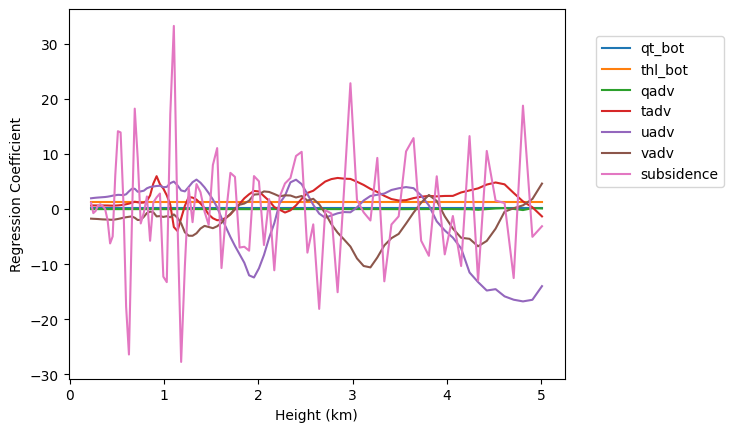

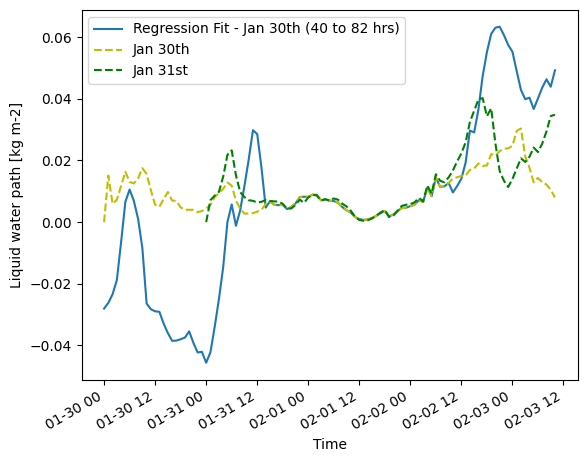

In [11]:
import numpy as np
import matplotlib.pyplot as pl
import netCDF4 as nc
import xarray as xr
from datetime import datetime
import netCDF4 as nc
from netCDF4 import Dataset
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
import metpy.calc as mpcalc
from metpy.units import units

#pwd='/users/PFS0220/graghuna/microhh/microhh/cases/eurec4a/case_1060T1_feb2_100m_36hrs/'
pwd='/fs/ess/PFS0220/eurec4a/case_feb2nd_1024_200m_jan30/'
nc_nums=1;
nc_vals = ['0000']
dz=40; z_ind=int(6000/dz);
startdate=datetime(2020,1,30,00,00)
label1='Jan 30th, 1024 points, 200m, jan30'
label2= 'Jan 30th, 1024 points, 200m, jan31'
label3= 'Jan 30th, 1024 points, 200m, jan31-rand 2'

for n in range(nc_nums):
    nc_filename='eurec4a.default.000' + nc_vals[n]+'.nc';
    microhh_out1=xr.open_dataset(pwd+nc_filename,decode_times=True)
    rootgroup = Dataset(pwd+nc_filename,"r")
    for group in rootgroup.groups:
        microhh_out1=xr.merge([microhh_out1, xr.open_dataset(pwd+nc_filename,group=group,decode_times=True)])
    if n==0:
        microhh_out=microhh_out1
    else:
        microhh_out=xr.merge([microhh_out,microhh_out1])

pwd='/fs/ess/PFS0220/eurec4a/case_feb2nd_1024_200m_jan31/'
nc_nums=1;
nc_vals = ['0000']

for n in range(nc_nums):
    nc_filename='eurec4a.default.000' + nc_vals[n]+'.nc';
    microhh_out1=xr.open_dataset(pwd+nc_filename,decode_times=True)
    rootgroup = Dataset(pwd+nc_filename,"r")
    for group in rootgroup.groups:
        microhh_out1=xr.merge([microhh_out1, xr.open_dataset(pwd+nc_filename,group=group,decode_times=True)])
    if n==0:
        microhh_out2=microhh_out1
    else:
        microhh_out2=xr.merge([microhh_out2,microhh_out1])
        
pwd='/fs/ess/PFS0220/eurec4a/case_feb2nd_1024_200m_jan31_rnd2/'
nc_nums=1;
nc_vals = ['0000']

for n in range(nc_nums):
    nc_filename='eurec4a.default.000' + nc_vals[n]+'.nc';
    microhh_out1=xr.open_dataset(pwd+nc_filename,decode_times=True)
    rootgroup = Dataset(pwd+nc_filename,"r")
    for group in rootgroup.groups:
        microhh_out1=xr.merge([microhh_out1, xr.open_dataset(pwd+nc_filename,group=group,decode_times=True)])
    if n==0:
        microhh_out3=microhh_out1
    else:
        microhh_out3=xr.merge([microhh_out2,microhh_out1])

pwd='/fs/ess/PFS0220/eurec4a/forcings/'
nc_filename='eurec4a_20200202_narenpitak_extended.kpt_inversion.nc'
era5_forcing=xr.open_dataset(pwd+nc_filename,decode_times=True)

############### ML Calcs ###################################
cp  = 1005.
Rd  = 287.

tlen=era5_forcing['time'].size
t1=40;t2=82;
z2=era5_forcing['nlev'].size-10;z1=era5_forcing['nlev'].size-100;

thl_bot = era5_forcing['open_sst'].values[0:tlen-1] / (era5_forcing['ps'].values[0:tlen-1]/1.e5)**(Rd/cp)
qt_bot = np.zeros((tlen-1))
wls=np.zeros((tlen-1,era5_forcing['nlev'].size))

##### MP Caclc #############################################
for n in range(0,tlen-1):
    sat_r = mpcalc.saturation_mixing_ratio(era5_forcing['ps'].values[n] * units.pascal , era5_forcing['open_sst'].values[n]* units.kelvin)
    qt_bot[n] = 0.981 * mpcalc.specific_humidity_from_mixing_ratio(sat_r)
    for k in range(0,era5_forcing['nlev'].size):
            wls[n,k] = mpcalc.vertical_velocity(era5_forcing['omega'].values[n,k] * units.pascal / units.second\
                        , era5_forcing['pressure_f'].values[n,k] * units.pascal, era5_forcing['t'].values[n,k] * units.kelvin) / (units.meter / units.second)
####### normalize function #####################################
def normalize(X):
    X_n=X/np.max(X)
    return X_n;
###### Normalize X variables ##########################################
qt_bot=normalize(qt_bot)
thl_bot=normalize(thl_bot)
for k in range(0,z2-z1):
    era5_forcing['qadv'].values[:,k]=normalize(era5_forcing['qadv'].values[:,k])
    era5_forcing['tadv'].values[:,k]=normalize(era5_forcing['tadv'].values[:,k])
    era5_forcing['uadv'].values[:,k]=normalize(era5_forcing['uadv'].values[:,k])
    era5_forcing['vadv'].values[:,k]=normalize(era5_forcing['vadv'].values[:,k])
    wls[:,k]=normalize(wls[:,k])
########### Scipy Linear Regression #########################
X = np.concatenate((qt_bot[:,None],thl_bot[:,None],era5_forcing['qadv'].values[0:tlen-1,z1:z2],era5_forcing['tadv'].values[0:tlen-1,z1:z2],\
                    era5_forcing['uadv'].values[0:tlen-1,z1:z2],era5_forcing['vadv'].values[0:tlen-1,z1:z2],wls[0:tlen-1,z1:z2]),axis=1) 

X_model = np.concatenate((qt_bot[t1:t2,None],thl_bot[t1:t2,None],era5_forcing['qadv'].values[t1:t2,z1:z2],era5_forcing['tadv'].values[t1:t2,z1:z2],\
                          era5_forcing['uadv'].values[t1:t2,z1:z2],era5_forcing['vadv'].values[t1:t2,z1:z2],wls[t1:t2,z1:z2]),axis=1) 

Y = microhh_out['ql_path'].isel(time=slice(None,None,12))
Y_model = microhh_out['ql_path'].isel(time=slice(t1*12,t2*12,12))
reg = LinearRegression().fit(X_model, Y_model)

################ Post Process ##############################
print(reg.score(X,Y))
#zsize=era5_forcing['nlev'].size
zsize=z2-z1
coeff=np.zeros((7,zsize))
label1=["qt_bot","thl_bot","qadv","tadv","uadv","vadv","subsidence"]

pl.figure()
coeff[0,:]=reg.coef_[0]
coeff[1,:]=reg.coef_[1]
for i in range(0,7):
    if i>1:
        coeff[i,:]=reg.coef_[(i-2)*zsize+2:zsize*(i-2+1)+2]
    pl.plot((era5_forcing['height_f']/1000).values[48,z1:z2],coeff[i,:],label=label1[i])
    pl.xlabel('Height (km)')
    pl.ylabel('Regression Coefficient')
pl.legend(bbox_to_anchor=(1.05, 0.5),loc="lower left")


pl.figure()
pl.plot(microhh_out['time'].isel(time=slice(None,None,12)).values,reg.predict(X),label='Regression Fit - Jan 30th (40 to 82 hrs)')
microhh_out['ql_path'].isel(time=slice(None,None,12)).plot.line('y--',label='Jan 30th')
microhh_out2['ql_path'].isel(time=slice(None,None,12)).plot.line('g--', label='Jan 31st')
pl.legend(loc="upper left")